## Train a model

The objective of this notebook is train and evaluate a given model specified in the parameters file.

In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import shutil
import json
import math
import time
from datetime import datetime
import logging
import socket

# Set terminal output (to send mesages to the terminal stdout)
terminal_output = open('/dev/stdout', 'w')
print('Execution of Notebook started at {}'.format(datetime.now()), file=terminal_output)

In [3]:
# Load external libraries
if socket.gethostname() == 'hughes-machine':
    external_libs_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
else:
    external_libs_path= '/storage/groups/ml01/code/andres.becker/master_thesis/workspace/libs'
print('External libs path: \n'+external_libs_path, file=terminal_output)

if not os.path.exists(external_libs_path):
    msg = 'External library path {} does not exist!'.format(external_libs_path)
    raise Exception(msg)

# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, external_libs_path)
# Load external libraries
from Models_V2 import Predef_models as predef_models
#from Utils import lr_schedule_Callback
#from Utils import save_best_model_Callback
from Utils import save_best_model_base_on_CMA_Callback
from Utils import evaluate_model
import Utils as utils
import Data_augmentation

Load model parameters:

In [4]:
# Do not touch the value of PARAMETERS_FILE!
# When this notebook is executed with jupyter-nbconvert (from script), 
# it will be replaced outomatically
PARAMETERS_FILE = '/home/hhughes/Documents/Master_Thesis/Project/workspace/scripts/Parameters/model_params/local/Quick_test_local.json'
#PARAMETERS_FILE = 'dont_touch_me-input_parameters_file'

# Open parameters
if os.path.exists(PARAMETERS_FILE):
    with open(PARAMETERS_FILE) as file:
        p = json.load(file)
else:
    raise Exception('Parameter file {} does not exist!'.format(PARAMETERS_FILE))

# IMPORTANT
# All outputs are saved using the model name and the name of the parameters file
# For instance, if model='ResNet50V2' and param file='test_1.json', then
# the model will be saved saved at p['model_path']/ResNet50V2/test_1

# Save parameter file path
p['parameters_file_path'] = PARAMETERS_FILE
p['external_libs_path'] = external_libs_path
# check and set default parameters
p, info = utils.set_model_default_parameters(p)
print(info)
print(p.keys())


Input parameters:

  Model parameters:
    Selected model: Quick_test
    Pretraining: 0
    Dense layers regularization (l1, l2): [0, 0]
    Conv layers regularization (l1, l2): [1, 0]
    Bias L2 reg (for dense and conv layers): 0
    Number of epochs: 5
    Loss function: huber
    Learning rate: 0.001
    Batch size: 32
    Verbose level: 1

  Output:
    Base name for files: Quick_test_local
    Model output: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local
    Clean base_path? 1

  Dataset:
     TFDS name: mpp_ds__normal_dmso_roar_bl
    Selected input channels: 
    ['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811', '13_PABPN1', '14_PCNA', '15_SON', '16_H3', '17_HDAC3', '19_KPNA1_MAX', '20_SP100', '21_NCL', '01_PABPC1', '02_CDK7', '03_RPS6', '05_Sm', '07_POLR2A', '09_CCNT1', '10_POL2RA_pS2', '11_PML', '12_YAP1', '13_POL2RA_pS5', '15_U2SN

Set logging:

In [5]:
p['number_of_epochs'] = 3
p['tf_ds_name'] = 'mpp_dataset__normal_dmso__g1'

In [6]:
# Set logging configuration
logging.basicConfig(
    filename=p['log_file'],
    filemode='w', 
    level=getattr(logging, 'INFO')
)
logging.info('Parameters loaded from file:\n{}'.format(PARAMETERS_FILE))
msg = 'Log file: '+p['log_file']
print(msg)
logging.info(info)
# Print location of the log file into the terminal
print(msg, file=terminal_output)

Log file: /home/hhughes/Documents/Master_Thesis/Project/workspace/logs/Quick_test_local.log


Create dirs where model output will be saved:

In [7]:
# If you want to avoid cleaning (deleting) model dir, then uncomment the next line:
#p['clean_model_dir'] = 0

base_path, model_path, checkpoints_path = utils.create_model_dirs(parameters=p)

msg = 'Base path:\n{}'.format(base_path)
msg += '\nModel path:\n{}'.format(model_path)
msg += '\nCheckpoints path:\n{}'.format(checkpoints_path)
logging.info(msg)
print(msg)

Warning! Directory /home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local already exist! Deleting...

Creating dir: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local
Base path:
/home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local
Model path:
/home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local/model
Checkpoints path:
/home/hhughes/Documents/Master_Thesis/Project/workspace/models/Quick_test/Quick_test_local/checkpoints


In [8]:
# Make tf to ignore GPU
if p['disable_gpu']:
    msg = "Cuda devices (GPUs) disabled"
    logging.info(msg)
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
msg = 'Physical GPU devises:\n{}'.format(physical_devices)
logging.info(msg)
print(msg)

#restrict GPU mem
if p['set_memory_growth']:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        msg = 'GPU Memory limited!'
    except:
        msg = 'It was not possible to limit GPU memory'
        
    logging.info(msg)
    print(msg)

Physical GPU devises:
[]
It was not possible to limit GPU memory


## Specify input channels

In [9]:
# Load Channels file
# TODO: CHANGE THIS (and parameters) to specify only the channel_df path, since it is the
# only stuff that is being used
with open(os.path.join(p['pp_path'], 'channels.csv')) as file:
    channels = pd.read_csv(file)
msg = 'Loaded channels file from:\n{}'.format(file)
logging.info(msg)

selected_channels = p['input_channels']
msg = 'Selected input channels:\n{}'.format(selected_channels)
logging.info(msg)
print(msg)
# Get selected channel ids
input_ids = np.array(channels.set_index(['name']).loc[selected_channels].channel_id.values)
msg = 'Corresponding input channel ids:\n{}'.format(input_ids)
logging.info(msg)
print(msg)
print(input_ids.shape)

Selected input channels:
['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811', '13_PABPN1', '14_PCNA', '15_SON', '16_H3', '17_HDAC3', '19_KPNA1_MAX', '20_SP100', '21_NCL', '01_PABPC1', '02_CDK7', '03_RPS6', '05_Sm', '07_POLR2A', '09_CCNT1', '10_POL2RA_pS2', '11_PML', '12_YAP1', '13_POL2RA_pS5', '15_U2SNRNPB', '18_NONO', '20_ALYREF', '21_COIL']
Corresponding input channel ids:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
(33,)


## Load Dataset

In [10]:
# Path where tf datasets are
dataset, metadata = tfds.load(
    name=p['tf_ds_name'], 
    data_dir=p['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=True, 
    shuffle_files=p['shuffle_files'],
    with_info=True)
msg = 'Tensorflow dataset {} loaded from:\n{}'.format(p['tf_ds_name'], p['local_tf_datasets'])
logging.info(msg)

# Load the splits
train_data, val_data = dataset['train'], dataset['validation']

Show information about the dataset:

In [11]:
metadata

tfds.core.DatasetInfo(
    name='mpp_dataset__normal_dmso__g1',
    version=1.0.0,
    description='Dataset containing images of Multiplexed protein maps.
The elements of this data sets are multichannel images of singel cells alongside with its transcription rate.
This Dataset was builded after a preprocessing using the python script Transform_MPPData_into_images_no_split_from_script.ipynb. During this preprocessing the original MPPData was:
- Converted into images.
- Cleaned. Border and mitotic cells were removed.
- Normalized. Each channel was normalized using scale parameters obtained from the training set.
- Target value (scalar) calculated. The transcription rate was approximated taking the average of the measured pixels of the channel 00_EU. It is important to mention that the the target value was calculated BEFORE the normalization process.

This Dataset contains only the cells with no perturbations (i.e. cells such that perturbation in ['normal', 'DMSO']). Although perturbation

In [12]:
metadata.splits

{'test': <tfds.core.SplitInfo num_examples=67>,
 'train': <tfds.core.SplitInfo num_examples=528>,
 'validation': <tfds.core.SplitInfo num_examples=66>}

In [13]:
metadata.features

FeaturesDict({
    'image': Tensor(shape=(224, 224, 37), dtype=tf.float32),
    'mapobject_id_cell': Text(shape=(), dtype=tf.string),
    'target': Tensor(shape=(1,), dtype=tf.float64),
})

## Process the data
Before training the network, we discriminate some channels, apply some linear transformations (90deg rotations and horizontal flipping) to augment the **Training** dataset, create the batches and shuffle them. Also, we perform other operations to improve performance.

**Tune performance**<br>
tf.data.Dataset.prefetch overlaps data preprocessing and model execution while training.
It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to **tf.data.experimental.AUTOTUNE** which will prompt the tf.data runtime to tune the value dynamically at runtime.

**Shuffling**<br>
dataset.shuffle() Randomly shuffles the elements of this dataset.
This dataset fills a buffer with `buffer_size` elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then `shuffle` will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

**reshuffle_each_iteration** controls whether the shuffle order should be different for each epoch.

Prepare datasets for training the CNN:

In [14]:
# Get some necessary stuff for data preprocessing
input_shape = np.array(metadata.features['image'].shape)
projection_tensor = Data_augmentation.get_projection_tensor(input_shape, input_ids)

# Prepare train and validation datasets
#train_data, val_data = Data_augmentation.prepare_train_and_val_TFDS_2(train_data, 
train_data, val_data = Data_augmentation.prepare_train_and_val_TFDS(train_data,
                                                                      val_data,
                                                                      projection_tensor,
                                                                      p)

Take a look into one image and a random transformation (random rotation+random horizontal flippig):

In [15]:
# Get one batch to print a cell
images, targets = next(iter(val_data))

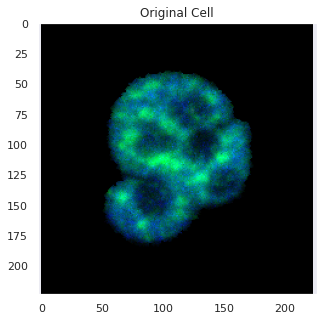

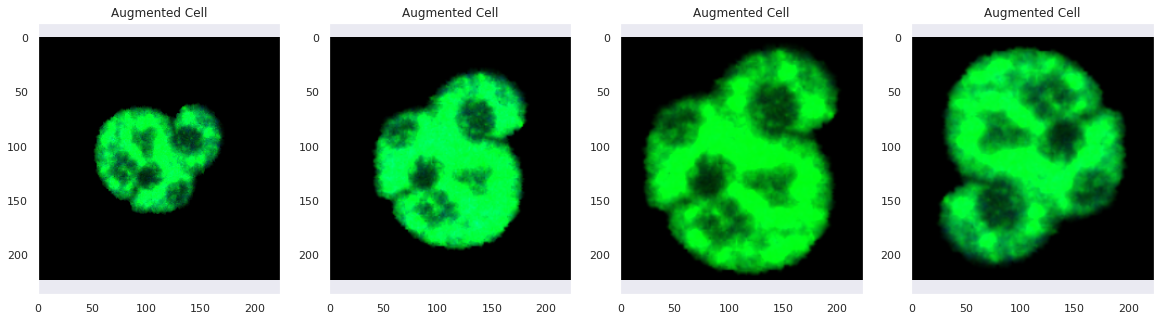

In [16]:
# Get one image from the training batch
img_idx = np.random.randint(0, p['BATCH_SIZE'])
# add an extra dim (like a batch)
image = tf.expand_dims(images[img_idx], axis=0)
Data_augmentation.visualize_data_augmentation(image, p)

## Model Selection

Models are selected from a group of predefined models in the class `Predef_models` (in `Models.py`). The name of the selected model is specified in the parameter `p['model_method']`.

First we need to init the `Predef_models` class:

In [17]:
# Init models class
models = predef_models()

# Select model
img_shape = metadata.features['image'].shape[:-1] + (input_ids.shape[0],)
model = models.select_model(model_name=p['model_name'], 
                            input_shape=img_shape,
                            conv_reg=p['conv_reg'],
                            dense_reg=p['dense_reg'],
                            bias_l2_reg=p['bias_l2_reg'],
                            pre_training=p['pre_training']
                           )

Model Quick_test selected!
Regularization:
conv_l1_reg: 1, conv_l2_reg: 0
dense_l1_reg: 0, dense_l2_reg: 0
Bias l2 reg: 0


Select the loss function and build the model:

In [18]:
# Sanity check: print model losses (one for each layer regularized (1 for bias reg and 1 for kernel reg))
model.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=788.541>]

In [19]:
# Select the loss function
if p['loss'] == 'mse':
    loss = tf.keras.losses.MeanSquaredError()
    
elif p['loss'] == 'huber':
    loss = tf.keras.losses.Huber(delta=1.0)
    
elif p['loss'] == 'mean_absolute_error':
    loss = tf.keras.losses.MeanAbsoluteError()
    
msg = '{} loss function selected. Building the model...'.format(p['loss'])
logging.info(msg)
print(msg)

metrics = ['mse', 'mean_absolute_error']
model.compile(optimizer=Adam(learning_rate=p['learning_rate']),
              loss=loss,
              metrics=metrics
             )
msg = 'Model compiled!'
logging.info(msg)

huber loss function selected. Building the model...


Take a look into the model architecture and number of parameters:

In [20]:
# Duplicates sys.stdout to the log file
model.summary(print_fn=utils.print_stdout_and_log)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      19072     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                1

Set callback to save best model accordingly to the average of the Validation MAE of the last 30, 20 and 10 epochs. It also save the best model with out any average:

In [21]:
avg_sizes = [11, 21, 31]
monitor='val_mean_absolute_error'

save_best_model = save_best_model_base_on_CMA_Callback(monitor, avg_sizes)
callbacks = [save_best_model]

Set tensorboard config (if active):

In [22]:
if p['tensorboard']:
    tb_dir_path = p['log_file'][:-4]+'_tensorboard'
    try:
        shutil.rmtree(tb_dir_path)
    except OSError as e:
        msg  = 'Tensorboard log dir {} could not be deleted!\n\nOSError: {}'.format(tb_dir_path, e)
        logging.error(msg)
        print(msg)
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir_path, histogram_freq=1)
    callbacks.append(tensorboard_callback)
    
    msg = 'Tensorboard file: {}'.format(tb_dir_path)
    logging.info('\n\n'+msg+'\n\n')
    print(msg)

Train the model:

In [23]:
msg = 'Starting model training...'
logging.info(msg)

In [24]:
# if LR_SCHEDULE given, then init lr scheduler callback
# commented since Adam+decreasing the learning during training make the model more prompt to overfitting
#if 'LR_SCHEDULE' in p.keys():
#    finish_warmup_and_lr_schedule = lr_schedule_Callback(utils.lr_schedule, p['LR_SCHEDULE'])
#    callbacks.append(finish_warmup_and_lr_schedule)

In [24]:
from Utils import print_progress_to_log as test_callback
test_call = test_callback(p['number_of_epochs'])
callbacks = [test_call]

In [27]:
# Save time before training
tic = time.time()

# Fit model
n_train = metadata.splits['train'].num_examples
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=p['number_of_epochs'],
                    callbacks=callbacks,
                    verbose=p['verbose_level'],
                    #steps_per_epoch=math.ceil(n_train/BATCH_SIZE),
                    )
toc = time.time()
print('Training time (in mins): {}'.format((toc-tic)/60))

Epoch 1/3
17/17 [==============================] - 31s 2s/step - loss: 547.6616 - mse: 132492.1875 - mean_absolute_error: 359.8071 - val_loss: 472.1099 - val_mse: 131796.3906 - val_mean_absolute_error: 359.1169
Epoch 2/3
17/17 [==============================] - 32s 2s/step - loss: 428.9841 - mse: 132187.3594 - mean_absolute_error: 359.3855 - val_loss: 389.0344 - val_mse: 131672.5000 - val_mean_absolute_error: 358.9439
Epoch 3/3
17/17 [==============================] - 33s 2s/step - loss: 375.7482 - mse: 131889.2969 - mean_absolute_error: 358.9677 - val_loss: 369.3234 - val_mse: 131546.3594 - val_mean_absolute_error: 358.7679
Training time (in mins): 2.2299496094385782


In [30]:
locals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', '_i2', 'tf', 'Adam', 'tfds', 'pd', 'np', 'plt', 'sns', 'sys', 'os', 'shutil', 'json', 'math', 'time', 'datetime', 'logging', 'socket', 'terminal_output', '_i3', 'key', 'external_libs_path', 'predef_models', 'Tee_Logger', 'save_best_model_base_on_CMA_Callback', 'evaluate_model', 'utils', 'Data_augmentation', '_i4', 'PARAMETERS_FILE', 'file', 'p', 'info', '_i5', '_i6', '_i7', 'base_path', 'model_path', 'checkpoints_path', 'msg', '_i8', 'physical_devices', '_i9', 'channels', 'selected_channels', 'input_ids', '_i10', 'dataset', 'metadata', 'train_data', 'val_data', '_i11', '_11', '_i12', '_12', '_i13', '_13', '_i14', 'input_shape', 'projection_tensor', '_i15', 'images', 'targets', '_i16', 'img_idx', 'image', '_i17', 'models', 'img_shape', 'model', '_i18', '_18', '_i19', 'loss'

In [27]:
eval_name='CMA_0'
# Load weights
type(save_best_model.best_models[eval_name][3])

list

### Plot Loss

In [ ]:
utils.plot_train_metrics(history=history.history, metrics=['loss']+metrics, p=p, figsize=(15,23))

In [ ]:
msg = 'Saiving trained model'
logging.info(msg)

# Save history
with open(os.path.join(base_path, 'history.json'), 'w') as file:
    json.dump(history.history, file, indent=4)
    
# Save CMA history
# First wee need to convert from np.int64 and np.float64 to regular python int and float
temp_dict = {}
for key in save_best_model.CMA_history.keys():
    temp_dict[key] = [[int(item[0]), float(item[1])] for item in save_best_model.CMA_history[key]]
with open(os.path.join(base_path, 'CMA_history.json'), 'w') as file:
    json.dump(temp_dict, file, indent=4)
    
# Save parameters
with open(os.path.join(base_path, 'parameters.json'), 'w') as file:
    json.dump(p, file, indent=4)

In [ ]:
# Load history
#path = ''
#with open(os.path.join(path, 'history.json'), 'r') as file:
#    history = json.load(file)
# Save parameters
#with open(os.path.join(base_path, 'parameters.json'), 'r') as file:
#    p = json.load(file)
#metrics = ['mse', 'mean_absolute_error']

# Model evaluation

In [ ]:
# Create data frame to save model metrics
metrics_df = pd.DataFrame()

## 1.- Last model

In [ ]:
# Evaluate model
model_eval = evaluate_model(p, model, projection_tensor)
model_eval.targets_df.head()

In [ ]:
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [ ]:
model_eval.get_metrics()
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

## 2.- Best model with no Center Moving Average (CMA_0)

In [ ]:
eval_name='CMA_0'
# Load weights
model.set_weights(save_best_model.best_models[eval_name][3])
# Save model
model.save(os.path.join(model_path, eval_name))
# Evaluate model
model_eval = evaluate_model(p, model, projection_tensor)
# Save model data (y_hat values and metrics)
model_eval.save_model_evaluation_data(base_path, eval_name=eval_name)
model_eval.targets_df.head()

In [ ]:
# Loss plot
utils.plot_train_metrics(history=history.history, 
                         metrics=['mean_absolute_error'], 
                         p=p,
                         figsize=(15,23))
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [ ]:
model_eval.get_metrics(CMA_size=0, 
                       CMA=save_best_model.best_models[eval_name][1], 
                       CMA_Std=save_best_model.best_models[eval_name][2], 
                       Epoch=save_best_model.best_models[eval_name][0])
metrics_df = metrics_df.append(model_eval.metrics_df, ignore_index=True)
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

## 3.- Best model wrt Central Moving Average of size 11 (CMA_11)

In [ ]:
eval_name='CMA_11'
# Load weights
model.set_weights(save_best_model.best_models[eval_name][3])
# Save model
model.save(os.path.join(model_path, eval_name))
# Evaluate model
model_eval = evaluate_model(p, model, projection_tensor)
# Save model data (y_hat values and metrics)
model_eval.save_model_evaluation_data(base_path, eval_name=eval_name)
model_eval.targets_df.head()

In [ ]:
# Loss plot
utils.plot_train_metrics(history=history.history, 
                         CMA_history=save_best_model.CMA_history[eval_name],
                         CMA_metric='mean_absolute_error',
                         metrics=['mean_absolute_error'], 
                         p=p,
                         title=eval_name,
                         figsize=(15,23))
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [ ]:
model_eval.get_metrics(CMA_size=11, 
                       CMA=save_best_model.best_models[eval_name][1], 
                       CMA_Std=save_best_model.best_models[eval_name][2], 
                       Epoch=save_best_model.best_models[eval_name][0])
metrics_df = metrics_df.append(model_eval.metrics_df, ignore_index=True)
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

## 4.- Best model wrt Central Moving Average of size 21 (CMA_21)

In [ ]:
eval_name='CMA_21'
# Load weights
model.set_weights(save_best_model.best_models[eval_name][3])
# Save model
model.save(os.path.join(model_path, eval_name))
# Evaluate model
model_eval = evaluate_model(p, model, projection_tensor)
# Save model data (y_hat values and metrics)
model_eval.save_model_evaluation_data(base_path, eval_name=eval_name)
model_eval.targets_df.head()

In [ ]:
# Loss plot
utils.plot_train_metrics(history=history.history, 
                         CMA_history=save_best_model.CMA_history[eval_name],
                         CMA_metric='mean_absolute_error',
                         metrics=['mean_absolute_error'], 
                         p=p,
                         title=eval_name,
                         figsize=(15,23))
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [ ]:
model_eval.get_metrics(CMA_size=21, 
                       CMA=save_best_model.best_models[eval_name][1], 
                       CMA_Std=save_best_model.best_models[eval_name][2], 
                       Epoch=save_best_model.best_models[eval_name][0])
metrics_df = metrics_df.append(model_eval.metrics_df, ignore_index=True)
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

## 5.- Best model wrt Central Moving Average of size 31 (CMA_31)

In [ ]:
eval_name='CMA_31'
# Load weights
model.set_weights(save_best_model.best_models[eval_name][3])
# Save model
model.save(os.path.join(model_path, eval_name))
# Evaluate model
model_eval = evaluate_model(p, model, projection_tensor)
# Save model data (y_hat values and metrics)
model_eval.save_model_evaluation_data(base_path, eval_name=eval_name)
model_eval.targets_df.head()

In [ ]:
# Loss plot
utils.plot_train_metrics(history=history.history, 
                         CMA_history=save_best_model.CMA_history[eval_name],
                         CMA_metric='mean_absolute_error',
                         metrics=['mean_absolute_error'], 
                         p=p,
                         title=eval_name,
                         figsize=(15,23))
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [ ]:
model_eval.get_metrics(CMA_size=31, 
                       CMA=save_best_model.best_models[eval_name][1], 
                       CMA_Std=save_best_model.best_models[eval_name][2], 
                       Epoch=save_best_model.best_models[eval_name][0])
metrics_df = metrics_df.append(model_eval.metrics_df, ignore_index=True)
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

# Compare metrics

In [ ]:
mask = metrics_df.Set == 'test'
metrics_df[~mask]

In [ ]:
mask = metrics_df.Set == 'val'
metrics_df[mask].sort_values(by=['MAE', 'Bias', 'Std'])

In [ ]:
# Save metrics
with open(os.path.join(base_path, 'metrics.csv'), 'w') as file:
    metrics_df.to_csv(file, index=False)

# Save a copy into a common dir to comparation among models
temp_path = os.path.join(p['model_path'], 'Model_Metrics_RI')
os.makedirs(temp_path, exist_ok=True)
with open(os.path.join(temp_path, p['basename']+'.csv'), 'w') as file:
    metrics_df.to_csv(file, index=False)

In [ ]:
msg = 'Notebook execution finished!'
logging.info(msg)